In [1]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow
from species_transport import set_BCs, set_Temp_BC, evolve_species
from visualization import plot_velocity_vector_field
import time
from Funcs import metric_L0, metric_RMS

In [2]:
N = 50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,N)
dt = dt_fluid_flow(dx, Fo=0.3)
dt

3.331945022907122e-05

In [3]:
# load the velocity field:
datap = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
u,v,_ = np.load(datap)
#plot_velocity_vector_field(u,v)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\vel_field\\test0\\UVP_N50.npy'

In [ ]:
# initial setup of the species distribution
CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,N))
O2[:] = .233
N2[:] = .767
T[:] = 300
Y = np.array([CH4, O2, N2, CO2, H2O])

# initial iterations before staerting the analysis
#Nt0 = int(500 * 3.2e-5 / dt)
Nt0 = 1

# total simulation time
t = 0.05

# time in [s] between two measurements
dt_measure = t / 200

# number of iterations between 2 convergence measurements
Nt = int(dt_measure / dt)

# number of convergence measurements
N_loop = int(t / dt_measure)


# number of convergence measurements
#N_loop = int(150 * 3.2e-5 / dt)

# placeholders for the respective metrics (here we evolve 3 species only)
L0 = np.zeros((3,N_loop))
L2 = np.zeros_like(L0)

# initial warm-up:
Y, T = evolve_species(Nt0, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)

t0 = time.time()
# convergence analysis:
for i in range(N_loop):
    
    t = i * dt * Nt + dt * Nt0 # current phyiscal time in [s]
    
    Y_old = np.copy(Y)
    Y, T = evolve_species(Nt, Y, T, dt, u, v, dx, dy, Ns_c, Nc_lw, chem=False, evolve_T=False)
    
    # measurements:
    for k in range(L0.shape[0]):
        L0[k,i] = metric_L0(Y_old[k], Y[k])
        L2[k,i] = metric_RMS(Y_old[k], Y[k])
print('CPU time [s]: ', time.time() - t0)

CPU time [s]:  0.9300212860107422


In [ ]:
def plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure, axs=None):
    
    t = np.arange(N_loop) * dt * Nt + dt * Nt0
    
    if axs is None:
        fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
    else:
        ax, ax2 = axs
        
    from species_transport import species_names

    for i in range(L0.shape[0]):
        ax.plot(t* 1e3, L0[i], label=species_names[i])
        ax2.plot(t * 1e3, L2[i], label=species_names[i])

    ax.set_xlabel('t [ms]')
    ax2.set_xlabel('t [ms]')
    if True:
        ax.set_yscale('log')
        ax2.set_yscale('log')
        #ax.set_xscale('log')
        #ax2.set_xscale('log')

    #ax.set_title(r'$\Delta \tilde{Y} = \frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
    #ax2.set_title(r'$\Delta \hat{Y} = RMS ( Y_n - Y_{n+1} ) / max |Yn| $')

    ax.set_title(r'metric 1')
    ax2.set_title(r'metric 2')
    
    ax.get_figure().suptitle(r'Relative variations of $Y_k$ over $\tau = t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(dt_measure * 1e3))
    s = r'$\Delta \hat{Y} = \frac{ max ( |Y_n -  Y_{n+1}| ) }{ max |Y_n| }$'
    #s += '\n'
    #s += r'$\tau = t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(dt_measure * 1e3)
    ax.text(0.95, 0.95, s, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)
    ax2.text(0.95, 0.95, r'$\Delta \hat{Y} = \frac{ RMS ( Y_n - Y_{n+1} ) }{ max |Yn| }$', verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes)
    for a in [ax, ax2]:
        a.axhline(1e-6, ls='--')
        a.set_xlim(left=1e-3)
        #a.plot(T, get_atol(T, amin, amax, tmax), label='atol')
    ax.legend(loc='lower left')
    #ax.set_ylabel(r'$\Delta \hat{Y} / \tau$ [(ms)$^{-1}$]')
    ax.set_ylabel(r'$\Delta \hat{Y}$')
    #ax.axvline(40, ls='--')

In [ ]:
from visualization import plot_station_analysis


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
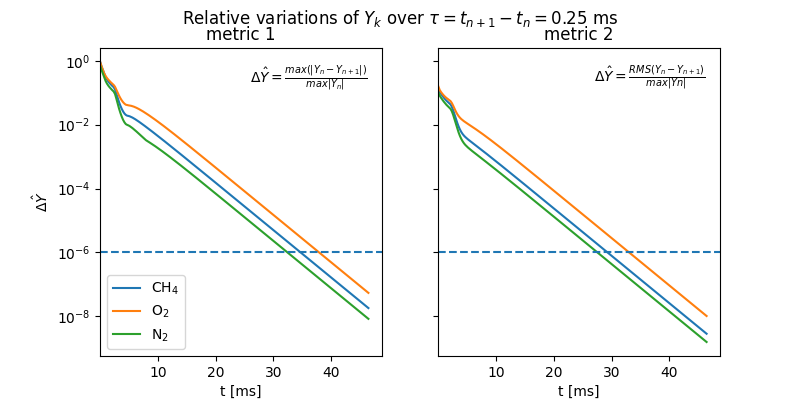

In [ ]:
%autoreload 1
plot_station_analysis(L0, L2, Nt, Nt0, N_loop, dt, dt_measure)

NameError: name 'plot_station_analysis' is not defined

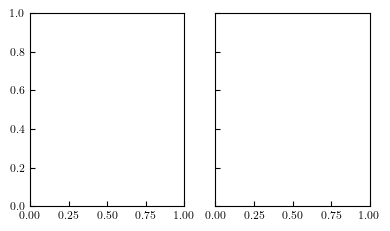

In [4]:
from plotting import set_size
plt.style.use('tex.mplstyle')
figsize = set_size(fraction=.7, aspect_r=0.4)
fig, axs = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
plot_station_analysis(axs)
plt.tight_layout()
if False:
    fig.savefig('figures/pre-combustion_station.svg')
plt.style.use('default')


We see that we are easily below the 10$^{-6}$ threshold if we take the stationarity time to be $t=0.04\,s$

In [ ]:
from species_transport import compute_Y_pre_combustion, save_Y_T, load_Y_T

In [ ]:
N_list = np.array([30,50,70,100,130, 160, 200,250])
N_list = np.array([70])

In [ ]:
import time

Chrono = np.zeros(N_list.size)

for i, N in enumerate(N_list):
    load_p = Path('data/vel_field/test0') / 'UVP_N{}.npy'.format(N)
    u,v,_ = np.load(load_p)
    
    t0 = time.time()
    Y,T = compute_Y_pre_combustion(N, u,v, t=0.04)
    Chrono[i] = time.time() - t0
    
    save_p = Path('data/species/test0') / 'N{}.npy'.format(N)
    save_Y_T(Y,T,save_p)

In [ ]:
Y,T = load_Y_T(save_p)
#fig, axs = plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
#plot_species_overview(Y,T, axs=axs)